In [133]:
import os
import sys

import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.linalg as lin
import scipy.special as spl
import scipy.integrate as inte

import scipy.interpolate as interp

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
k = con.physical_constants['Boltzmann constant in eV/K'][0]

In [2]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': False,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


In [3]:
def position_operator(basis_size):
    """ Returns matrix representation of the position operator in the 
        basis of number states. Truncated at dimension 'basis size'. 
        """
    x = np.zeros((basis_size, basis_size))
    for n in range(basis_size-1):
        x[n, n+1] = 1/2**0.5 * np.sqrt(n+1)
        x[n+1, n] = 1/2**0.5 * np.sqrt(n+1)
    return x

In [4]:
def x_tothe_k(k, basis_size):
    x = position_operator(basis_size)
    return np.linalg.matrix_power(x, k)

In [5]:
def ham_g(basis_size, lambda_array):
    """ Returns matrix representation of (unitless) nuclear Hamiltonian 
        in the electronic ground state for the general anharmonic 
        oscillator truncated at dimension 'basis_size'. 
        
        The arg 'lambda_array' is expected to be 1D and contains the 
        scalar prefactors at each order of the polynomial potential 
        energy surface. The potential is therefore a polynomial of order 
        len(lambda_array) + 1.
        """
    H_prime = np.zeros((basis_size, basis_size)) 
    ## Define unperterbed harmonic hamiltonian 
    H_0 = np.diag(np.arange(0, basis_size))
    
    poly_order_plus_1 = len(lambda_array)
    for order in range(poly_order_plus_1):
        H_prime += lambda_array[order]*x_tothe_k(order, basis_size)
            
    H_g = H_0 + H_prime
#     H_g -= np.identity(basis_size)*lambda_array[0]
    return H_g

def displaced_ham_e(H_g, zp_energy, d):
    """ Returns matrix representation of (unitless) nuclear Hamiltonian 
        in the electronic ground state for the general anharmonic 
        oscillator truncated at dimension 'basis_size'. 
        
        The arg 'lambda_array' is expected to be 1D and contains the 
        scalar prefactors at each order of the polynomial potential 
        energy surface. The potential is therefore a polynomial of order 
        len(lambda_array) + 1.
        """ 
    basis_size = H_g.shape[0]
    a = np.zeros((basis_size, basis_size))
    for n in range(basis_size-1):
        a[n, n+1] = np.sqrt(n+1)
    displacement_op = lin.expm(d*a.T - d*a)
        
    H_e = (
        displacement_op @ H_g @ displacement_op.T
        + 
        zp_energy * np.identity(basis_size)
        )
    return H_e

In [6]:
def displaced_lambdas(
    lambda_array, 
    d, 
    include_H0_contri=True):
    """ Given the polynomial or order n = len('lambda_array')-1
            lambda_array[0]
            +
            lambda_array[1] * x
            + 
            lambda_array[2] * x**2
            ...
            + 
            lambda_array[-1] * x**n
        this function returns the coefficients upon introducing the 
        displacement 
            x -> x-d
        """
    n = len(lambda_array) - 1
    
    lambda_matrix = np.tri(n+1)
    lambda_matrix *= np.asarray(lambda_array)[:, None]
    
    ## For each term in the polynomial, we need to expand the binolial
    ## and resort coefficients into lambda array. 
    for m in range(0, n+1):
         for k in range(0, m):
            lambda_matrix[m, k] *= (
                spl.factorial(m)/(spl.factorial(k)*spl.factorial(m-k))
                )*(-d)**(m-k)
    new_lambdas = np.sum(lambda_matrix, axis=0)

    if include_H0_contri:
        ## Add contribution from displacing H_0
        new_lambdas[:2] += [d**2/2, -d]
    
    return new_lambdas

In [7]:
displaced_lambdas(
    [1, 2, 3 ,4], 
    0,) 

array([1., 2., 3., 4.])

In [98]:
def rho_e(H_e, T):
    if T is 0:
        return np.identity(H_e.shape[0])
    density_matrix_e = lin.expm(-H_e/(k*T))
    density_matrix_e /= np.trace(density_matrix_e)
    print('np.trace(density_matrix_e) = ', np.trace(density_matrix_e))
    return density_matrix_e

In [99]:
def gap_fluc_op(basis_size, lambda_g_array, lambda_e_array, T):
    """ Returns energy gap fluctuation operator """
    density_matrix_e = rho_e(ham_g(basis_size, lambda_e_array), T=T) 
    
    delta = np.zeros((basis_size, basis_size))
    for n in range(len(lambda_e_array)):
        xk = x_tothe_k(n, basis_size)
        delta += (
            (lambda_g_array[n] - lambda_e_array[n])
            *
            (
                xk 
                - 
                np.identity(basis_size)
                *np.trace(xk@density_matrix_e)
                )
            )
    return delta

In [10]:
gap_fluc_op(4, [0,0,1], [1,0,2], T=0)

array([[ 8.5       ,  0.        , -0.70710678,  0.        ],
       [ 0.        ,  7.5       ,  0.        , -1.22474487],
       [-0.70710678,  0.        ,  6.5       ,  0.        ],
       [ 0.        , -1.22474487,  0.        ,  7.5       ]])

In [11]:
def a_matrix(H_e, Delta, order):
    miHe = -1j*H_e/hbar
    A = np.block([
        [miHe,             Delta,  ],
        [np.zeros_like(Delta), miHe,]
        ])
    for o in range(1, order-1):
        right_col = np.block([np.zeros_like(Delta)]*o + [Delta]).T
        bottom_row = np.block([np.zeros_like(Delta)]*(o+1) + [miHe])
    
        A = np.block([
            [A, right_col],
            [bottom_row]
            ])
    return A

In [12]:
def taylor_expm(A, n):
    e_A = np.identity(A.shape[-1], dtype='complex')
    if A.ndim is 3:
        e_A = e_A[None, ...]
    for i in range(1, n):
        e_A = e_A + (1/spl.factorial(i))*np.linalg.matrix_power(A, i)
    return e_A

In [13]:
def eigy_expm(A):
    vals,vects = np.linalg.eig(A)
    return np.einsum('...ik, ...k, ...kj ->...ij',
                     vects,np.exp(vals),np.linalg.inv(vects))
def loopy_expm(A):
    expmA = np.zeros_like(A)
    for n in range(A.shape[0]):
        expmA[n,...] = lin.expm(A[n,...])
    return expmA

def big_b_tilde(
    t, 
    order_n, 
    H_e, 
    rho_ex, 
    A=None,
    e_At=None,
    return_e_At_in_dict=False):
    
    """ Return shorthand B_n coefficient from Anda's paper 
            B_n = (i/hbar)^n * Tr{e^-iH_et [e^At]_[N-n, N] * rho_ex}
        """
#     print(f"Inside Bn, t = {t}")
    if type(t) is np.ndarray:
        H_e = H_e[None, ...]
        t = t[:, None, None]
        if A is not None:
            A = A[None, ...]
        exp_func = loopy_expm
#         exp_func = lambda a: taylor_expm(a, 100)
    else:
        exp_func = lin.expm
#     print(f"Shape of H_e inside B_n = {H_e.shape}")
#     print(f"Shape of A inside B_n = {A.shape}")
        
    ## First step compute matrix exponentials at time t
    e_iHet = exp_func(1j*H_e*t/hbar)
#     print(f"e_iHet = {e_iHet}")
    if A is not None:
        e_At = exp_func(A*t)
    
#     print(f"e_At = {e_At}")
    ## Navigate block array
    block_size = H_e.shape[-1]
    
    N = round(e_At.shape[-1]/block_size)
#     print(f" A block indexed from {(N-order_n-1)} to {N-order_n}")
    Bn_array = (
        (
            -1j
            /
            hbar
            )**order_n 
        *
        e_iHet
        @
        e_At[
            ...,
            (N-order_n-1)*block_size:(N-order_n)*block_size, 
            (N-1)*block_size:
            ]
        @
        rho_ex
        )
    Bn = np.trace(Bn_array, axis1=-2, axis2=-1)
    if return_e_At_in_dict:
        return {'B_n':Bn, 'e_At':e_At}
    return Bn

In [14]:
def flu_lineshape(
    omega, 
    gamma, 
    H_e,
    rho_ex,
    A,
    t_max=1000,
    t_points=100,
    return_integrand=False):
    """ Implement equation 31 from Anda """
    
    def integrand(_t):
        B_2_dict = big_b_tilde(
            _t, 
            order_n=2, 
            H_e=H_e, 
            rho_ex=rho_ex, 
            A=A,
            e_At=None,
            return_e_At_in_dict=True)
        B_2 = B_2_dict['B_n']
        e_At = B_2_dict['e_At']
#         print(f"e_At = {e_At}")
        B_3 = big_b_tilde(
            _t, 
            order_n=3, 
            H_e=H_e, 
            rho_ex=rho_ex, 
#             A = A,
            e_At=e_At,
            )
        B_4 = big_b_tilde(
            _t, 
            order_n=4, 
            H_e=H_e, 
            rho_ex=rho_ex, 
            e_At=e_At,)
        B_5 = big_b_tilde(
            _t, 
            order_n=5, 
            H_e=H_e, 
            rho_ex=rho_ex, 
            e_At=e_At,)
        B_6 = big_b_tilde(
            _t, 
            order_n=6, 
            H_e=H_e, 
            rho_ex=rho_ex, 
            e_At=e_At,)
#         print(f"B_2 = {B_2}")
#         print(f"B_3 = {B_3}")
        exp_arg = (
            B_2 
            + 
            B_3
            ## Stop here fore 3rd order Cum. expansion
            +
            B_4
            -
            (B_2**2)/2 
            ## Stop here for 4th order Cum. expansion
            +
            B_5
            -
            B_2*B_3
            ## Stope here fore 5th order Cum. expansion
            +
            B_6
            -
            B_2*B_4
            -
            (B_3**2)/2
            +
            (B_2**3)/3
            )

        ## Return integrand with time on last dimensions and omegas on 
        ## first.
#         print(f"omega = {omega}")
#         print(f"gamma = {gamma}")
#         print(f"_t = {_t}")
#         print(f"exp_arg = {exp_arg}")
        _integrand = np.real(
            np.exp(
                (-1j*omega[:, None] - gamma)*_t[None, :]
                +
                exp_arg[None, :]) 
                )
#         print(f"integrand = {_integrand}")
        return _integrand

    ## Build t vector
    ts = np.linspace(0, t_max, t_points)*1e-15
    
    if return_integrand:
        return (ts, integrand(ts))
    ## Integrate with trapazoid rule
    integral = inte.trapz(integrand(ts), ts, axis=-1)
    
    ## Integrate with scipy quadriture function
#     integral = integ.quad(integrand, 0, t_max*1e-15
    ## Integrate by direct Rieman sum
#     integral = np.zeros(len(omega))
#     for t in ts:
#         integral += integrand(t)
#     integral *= ts[1]-ts[0]
    return integral/(2*np.pi*hbar)

Plot B2 to compare to Mukamel model 

# Trying to reproduce Anda's first example

The Morse potential expanded to 12th order yields the polynomial, 
\begin{multline}
    0.500141 x^{2} - 0.0456629 x^{3} + 0.00243193 x^{4} - 0.000095158 x^{5} \\
    + 2.99251*10^{-6} x^{6} - 7.93207*10^{-8} x^{7} + 1.82486*10^{-9} x^{8} \\
    - 3.71702*10^{-11} x^{9} + 6.80059*10^{-13} x^{10} - 1.13*10^{-14} x^{11} \\
    + 1.72033*10^{-16} x^{12}
\end{multline}

In [113]:
Anda_fig1 = np.loadtxt(
    os.path.join('..', 'data', 'Anharmonic_graph.txt'), 
#     skiprows=0, 
    delimiter=','
    )

In [105]:
mor_lam_g = [
    0,
    0,
    0.500141 - .5, ## to account for H_0 
    - 0.0456629,
    0.00243193,
    - 0.000095158,
    2.99251*1e-6,
    - 7.93207*1e-8,
    + 1.82486*1e-9,
    - 3.71702*1e-11,
    6.80059*1e-13,
    - 1.13*1e-14,
    + 1.72033*1e-16,
    ]

d = 1.6

## Number of oscillator states used for representation of general 
## potential energy eigenstates
basis_size = 20
## Energy spacing of unperterbed vibration
hbarw0_mor = 1

## Build excited state lambdas from ground state and displacement
mor_lam_e = displaced_lambdas(mor_lam_g, d=d)

## Assign the temperature
T_mor = .3*hbarw0_mor/k

## Define Vibrational Hamiltonians in units of energy (by multiplying by 
## the unperturbed vibrational energy spacing).
## -----
## Vibrational Hamiltonian in the electronic ground state
Hg_mor = ham_g(basis_size, mor_lam_g)*hbarw0_mor
## Vibrational Hamiltonian in the electronic excited state
He_mor = ham_g(basis_size, mor_lam_e)*hbarw0_mor

## Define the Energy Gap fluctuation operator (in units of energy as for 
## the vibrational Hamiltonians above)
D_mor = gap_fluc_op(basis_size, mor_lam_g, mor_lam_e, T_mor)*hbarw0_mor
## Define the A matrix for use in the matrix eponential theorm used to
## calculate the Cumulants. 
A_mor = a_matrix(He_mor, D_mor, order=7)
## Define density matrix from operators already define. 
rho_mor = rho_e(He_mor, T_mor)


np.trace(density_matrix_e) =  0.9999999999999998
np.trace(density_matrix_e) =  0.9999999999999998


In [106]:
hbar_omegas_mor = np.linspace(-5, 5, 200)
lineshape_mor = flu_lineshape(
    omega=hbar_omegas_mor/hbar, 
    gamma=.18/hbar, 
    H_e=He_mor,
    rho_ex=rho_mor,
    A=A_mor,
    t_max=30,
    t_points=600,
    # return_integrand=True
    )

In [114]:
## Plot integrand in time domain
# ts, integrands = lineshape_mor
# for integ in integrands:
#     plt.plot(ts, integ)

In [119]:
def mag_norm(y_values):
    max=np.max(y_values)
    
    return y_values/max

# def norm(y_values):
#     """ Magnitude normalize data. """
#     return y_values/y_values.max()


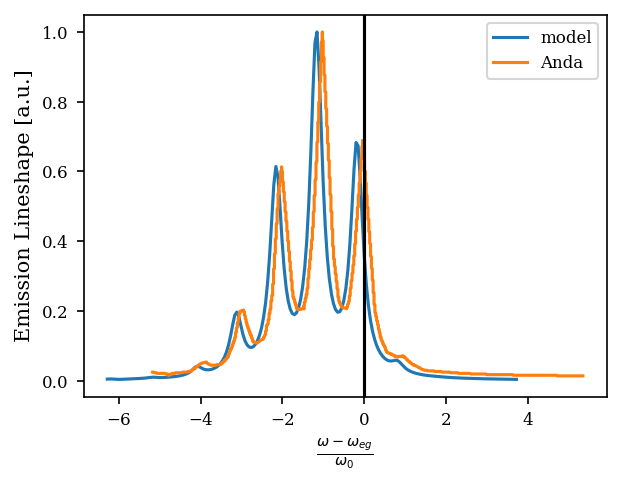

In [120]:
plt.plot(
    hbar_omegas_mor-d**2/2, 
    mag_norm(lineshape_mor), 
    label='model'
    )
plt.plot(
    Anda_fig1.T[0], 
    mag_norm(Anda_fig1.T[1]), 
    label='Anda' 
    )

plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.axvline(0, c='k')

plt.legend()

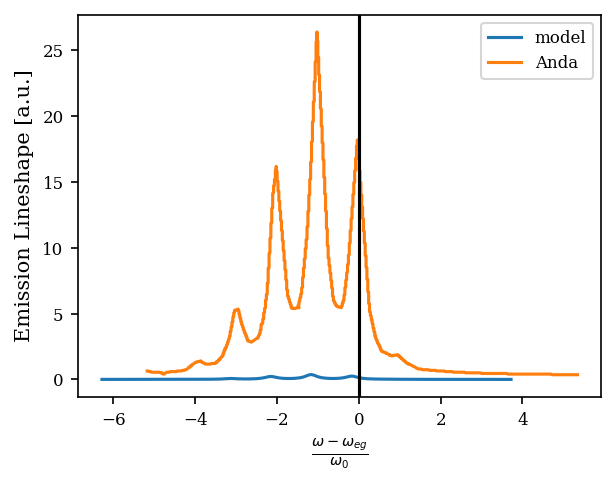

In [132]:
plt.plot(
    hbar_omegas_mor-d**2/2, 
    (lineshape_mor), 
    label='model'
    )
plt.plot(
    Anda_fig1.T[0], 
    (Anda_fig1.T[1]), 
    label='Anda' 
    )

plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)
plt.axvline(0, c='k')

plt.legend()

In [127]:
trimmed_fig = Anda_fig1.T[0][np.argwhere(Anda_fig1.T[0]<3)]

In [129]:
interped_model = interp.interp1d(hbar_omegas_mor-d**2/2, lineshape_mor)

diff = interped_model(trimmed_fig) / Anda_fig1.T[1]

print(diff)

[[0.00554707 0.00554707 0.00599151 ... 0.00998473 0.00998473 0.00998473]
 [0.00553795 0.00553795 0.00598166 ... 0.00996831 0.00996831 0.00996831]
 [0.00552887 0.00552887 0.00597185 ... 0.00995197 0.00995197 0.00995197]
 ...
 [0.00291665 0.00291665 0.00315033 ... 0.00524997 0.00524997 0.00524997]
 [0.00288456 0.00288456 0.00311567 ... 0.0051922  0.0051922  0.0051922 ]
 [0.00285646 0.00285646 0.00308532 ... 0.00514163 0.00514163 0.00514163]]


In [130]:
max_Anda = np.max(Anda_fig1.T[1])
max_model = np.max(lineshape_mor)
factor_off = max_Anda/max_model
print(factor_off)

72.04424950837522


In [141]:
energy_max_Anda = Anda_fig1.T[0][np.argmax(Anda_fig1.T[1])]
energy_max_model =  (hbar_omegas_mor-d**2/2)[np.argmax(lineshape_mor)] 

energy_shift =  energy_max_Anda - energy_max_model

print(energy_max_Anda, energy_max_model, energy_shift)

-1.0239 -1.1543718592964822 0.1304718592964822


In [149]:
(d**2/2)/energy_shift

9.810544640828246

# General Morse potential excited state

In [71]:
def lambda_generator_Morse(a, D):
    """ This is a function that returns the lambda prefactors for a Morse
        Potential expanded to 12th order. 
        
        Returns:
        -------
            lambdas: an array of perterbed polynomial prefactors determined from Mathematica
        """
    lambdas = np.array([
        0, 
        0,
        ## Make sure to subtract .5 from harmonic term to accound for the 
        ## unperterbed potential 
        a**2. * D - 0.5,
        -a**3. * D,
        (7/12) * a**4 * D,
        (-1/4) * a**5 * D,
        (31/360) * a**6 * D,
        (-1/40) * a**7 * D,
        (127/20160) * a**8 * D,
        (-17/12096) * a**9 * D,
        (73/259200) * a**10 * D,
        (-31/604800) * a**11 * D,
        (2047/239500800) * a**12 * D,
        ])

    
    return lambdas

In [87]:
lambda_generator_Morse(alpha, D)

array([ 0.00000000e+00,  0.00000000e+00, -4.91900000e-01, -7.29000000e-04,
        3.82725000e-05, -1.47622500e-06,  4.57629750e-08, -1.19574225e-09,
        2.71177260e-11, -5.44489775e-13,  9.82003323e-15, -1.60848685e-16,
        2.41390952e-18])

In [96]:
displaced_lambdas(lambda_generator_Morse(alpha, D), d=1.6)

array([ 1.43934522e+00, -1.93183051e+00,  2.35138423e-01, -6.09465157e-02,
        3.12145294e-03, -1.19191781e-04,  3.67804546e-06, -9.58934386e-08,
        2.17237112e-09, -4.35859814e-11,  7.83529454e-13, -1.24317449e-14,
        1.44834571e-16])

In [100]:
## Energy spacing of unperterbed vibration
hbarw0_mor = 1
# D = hbarw0_mor
D = 60
alpha = 0.09
gamma=.18/hbar

mor_lam_g = lambda_generator_Morse(D, alpha)

## Build excited state lambdas from ground state and displacement
mor_lam_e = displaced_lambdas(mor_lam_g, d=1.6)

## Assign the temperature
T_mor = 294

## Number of oscillator states used for representation of general 
## potential energy eigenstates
basis_size = 20
## Define Vibrational Hamiltonians in units of energy (by multiplying by 
## the unperturbed vibrational energy spacing).
## -----
## Vibrational Hamiltonian in the electronic ground state
Hg_mor = ham_g(basis_size, mor_lam_g)*hbarw0_mor
## Vibrational Hamiltonian in the electronic excited state
He_mor = ham_g(basis_size, mor_lam_e)*hbarw0_mor

## Define the Energy Gap fluctuation operator (in units of energy as for 
## the vibrational Hamiltonians above)
D_mor = gap_fluc_op(basis_size, mor_lam_g, mor_lam_e, T_mor)*hbarw0_mor
# ## Define the A matrix for use in the matrix eponential theorm used to
# ## calculate the Cumulants. 
# A_mor = a_matrix(He_mor, D_mor, order=7)
# ## Define density matrix from operators already define. 
# rho_mor = rho_e(He_mor, T_mor)


np.trace(density_matrix_e) =  nan


C:\Users\emily\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [79]:
hbar_omegas_mor = np.linspace(-2, 2, 200)
lineshape_mor = flu_lineshape(
    omega=hbar_omegas_mor/hbar, 
    gamma= gamma, 
    H_e=He_mor,
    rho_ex=rho_mor,
    A=A_mor,
    t_max=200,
    t_points=600,
#     return_integrand=True
    )

C:\Users\emily\Miniconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in exp
C:\Users\emily\Miniconda3\lib\site-packages\numpy\lib\function_base.py:4062: RuntimeWarning: invalid value encountered in add
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
C:\Users\emily\Miniconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Text(0, 0.5, 'Emission Lineshape [a.u.]')

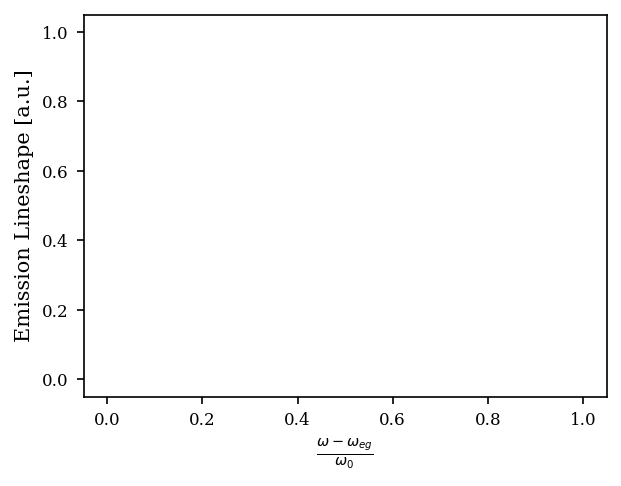

In [77]:
plt.plot(hbar_omegas_mor, lineshape_mor)
plt.xlabel(r'$\frac{\omega - \omega_{eg}}{\omega_0}$', fontsize=10)
plt.ylabel(r'Emission Lineshape [a.u.]', fontsize=10)